In [1]:
from timeit import default_timer as timer
import matplotlib.pylab as plt
import numpy as np
from numba import jit
from IPython import display
from tensorflow.keras import layers
import tensorflow as tf

In [2]:
IMG_W, IMG_H = 128, 128 # mesh
lim, max_iter = 255 ** 2, 200 # limits 


x = np.linspace(-1.6, 1.6, IMG_W)
y = np.linspace(-1.6, 1.6, IMG_H)


@jit(nopython=True, parallel=True)
def create_juliaset(x, y, num_real, num_imag):
    julia = np.zeros((x.size, y.size), dtype=np.float32)
    
    c = complex(num_real, num_imag) 
    for j in range(y.size):
        for i in range(x.size):
            z = complex(x[i], y[j])
            ite = 0
            while (z.real*z.real + z.imag*z.imag) < lim and ite < max_iter:
                z = z*z + c
                ite += 1
            julia[j, i] = ite

    julia -= julia.min()
    julia /= julia.max()
    return julia

0.014121985004749149 secs


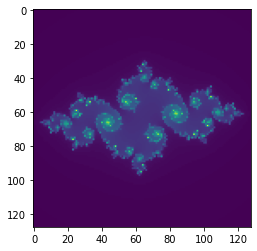

In [24]:
s = timer()
img = create_juliaset(x, y, -0.76691 , 0.124281)
e = timer()
print(e - s, "secs")

plt.imshow(img)

In [4]:
def make_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(2,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) 

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, IMG_H, IMG_W, 1)
    
    model.add(layers.Reshape((IMG_H, IMG_W)))
    assert model.output_shape == (None, IMG_H, IMG_W)

    return model

model = make_model()

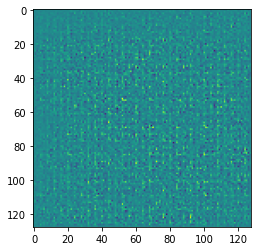

In [5]:
params = np.array([[-0.7769 , 0.12428]], dtype=np.float32)
generated_image = model(params, training=False)

plt.imshow(generated_image.numpy()[0,:,:])

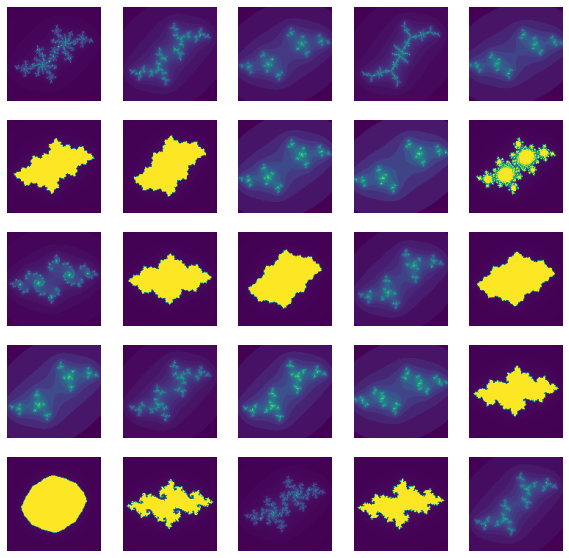

In [6]:
real_rand_mean = -0.5
imag_rand_mean = 0.5

def create_rand_input(n):
    t = np.random.uniform(-.5, .5, (n,2))
    t[:, 0] = t[:, 0] + real_rand_mean
    t[:, 1] = t[:, 1] + imag_rand_mean
    return t.astype(np.float32)

def plot_group(buff):
    plt.figure(figsize=(10,10))
    n_rows = int(np.sqrt(buff.shape[0]))
    
    for i in range(n_rows**2):
        img = buff[i]
        plt.subplot(n_rows, n_rows, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


n_rows = 5
buff = np.zeros((n_rows**2, IMG_H, IMG_W))
feats = create_rand_input(n_rows**2)
for i in range(n_rows**2):
    img = create_juliaset(x, y, feats[i, 0], feats[i, 1])
    buff[i, :, :] = create_juliaset(x, y, feats[i, 0], feats[i, 1])
    
plot_group(buff)


In [7]:
def loss_func(target ,gen_output):
    return tf.keras.losses.MSE(target , gen_output)

optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
BATCH_SIZE = 128
EPOCHS     = 100
STEPS_PER_EPOCH = 50

real_images = np.zeros((BATCH_SIZE, IMG_H, IMG_W), dtype=np.float32)

@tf.function
def train_step():
    feats = create_rand_input(BATCH_SIZE)
    for i in range(BATCH_SIZE):
        real_images[i, :, :] = create_juliaset(x, y, feats[i, 0], feats[i, 1])
    
    with tf.GradientTape() as gtape:
        generated_images = model(feats, training=True)
        loss = loss_func(real_images, generated_images)
        
    gradients = gtape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


In [9]:
model = make_model()
losses = []

for epoch in range(EPOCHS):
    s = timer()
    loss = 0.0
    for i in range(STEPS_PER_EPOCH):
        l = train_step()
        loss += l.numpy().mean()
    e = timer()
    loss /= STEPS_PER_EPOCH
    losses.append(loss)
    
    display.clear_output(wait=True)
    print(f"finish epoch {epoch} in {e - s} secs. loss = {loss}")
            

finish epoch 99 in 17.162884076999035 secs. loss = 0.0027720921300351618


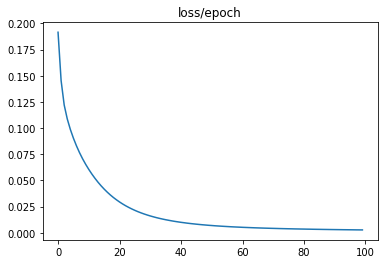

In [10]:
plt.subplot(1, 1, 1)
plt.title("loss/epoch")
plt.plot(losses)
plt.show()

In [11]:
model.save('julia_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: julia_model/assets


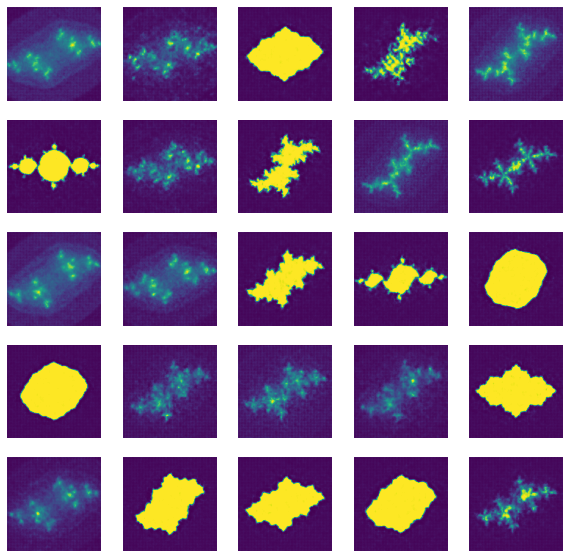

In [20]:
n_rows = 5
feats = create_rand_input(n_rows**2)
images = model.predict(feats)
    
plot_group(images)

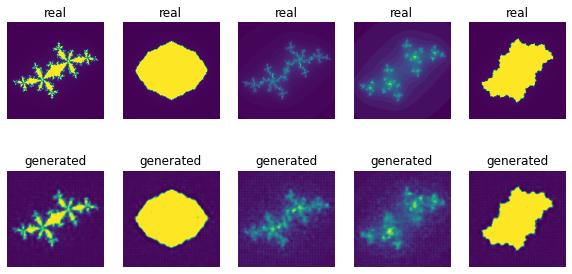

In [22]:
def plot_single(n_rows, img, title, i):
    plt.subplot(2, n_rows, i)
    plt.title(title)
    plt.imshow(img)
    plt.axis('off')

def plot_compare(feats):
    n_rows = feats.shape[0]
    plt.figure(figsize=(10, 5))
    
    generated_images = model.predict(feats)
    real_images = [create_juliaset(x, y, feats[i, 0], feats[i, 1]) for i in range(n_rows)]

    i=1
    for real, gen in zip(real_images, generated_images):
        plot_single(n_rows, real, 'real', i)
        plot_single(n_rows, gen, 'generated', i+n_rows)
        i+=1
    
    plt.show()
    

plot_compare(create_rand_input(5))

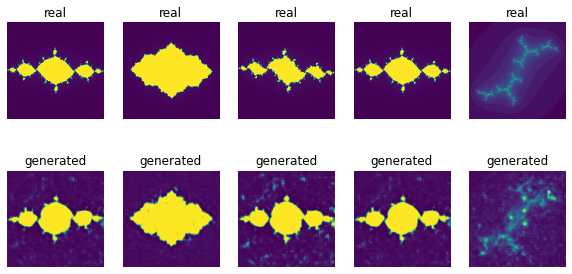

In [34]:
real_rand_mean = -0.5
imag_rand_mean = 0.5
feats = np.array([
    [-1.05, -0.05],
    [-0.5, -0.05],
    [-1.05, -0.15],
    [-1.05, -0.05],
    [-0.05, 1.05]
])

plot_compare(feats)